# Free Lunch (there is such a thing!)
Working with NYC DOE to develope a method to optimize school lunch and breakfast reimbursements from the federal and state government.

###Overview
The Community Eligibility Provision (CEP) is program aimed at streamlining reimbursement claims. It requires that participating schools provide universal breakfast and lunch service, where all meals are served at no cost to the students.

###Reimbursement Rules:
Schools get reimbursed at either the "free" rate or the "paid" rate for each meal. (Other programs have an additional "reduced" rate, but that does not apply here). The fraction of meals that get reimbursed at the "free" rate is determined by the group the school is enrolled under. This fraction we will call the $threshold$. The rest of the meals get reimbursed at the "paid" rate. 

At a minimum, the USDA covers the paid rate,$r_{lunch/breakfast,paid}$, for all meals.This includes total number of breakfasts for all schools $\sum_{s}B_s$, and total number of lunches for all schools $\sum_{s}L_s$. 

This $base$ reimbursement is independant of the groupings: 
$base = r_{lunch,paid} \sum_{s}L_s + r_{breakfast,paid} \sum_{s}B_s $.

The total Reimbursement, $R$, is

$\begin{align}
R = \sum_{s} Min(1,threshold_s) [\Delta r_{lunch} L_s  + \Delta r_{breakfast} B_s] + base
\end{align}$

> where 
> $\begin{align}
\Delta r_{breakfast} &= r_{breakfast,free} - r_{breakfast,paid} \\
\Delta r_{lunch} &= r_{lunch,free} - r_{lunch,paid}
\end{align}$

> and the $threshold_s$ for each school, $s$, is determined it's group, $g$. It is the fraction of "identified students" $I_s$ for all schools in the group $g$ to the total number of "enrolled students" $N_s$ for all schools in the group, multiplied by a constant. This constant is set by the USDA at 1.6 but may change in subsequent years. $I_s$ and $N_s$ are based on enrollment in the previous school year. "Identified students" are those deemed categorically eligible for free meals, primarily due to receiving some sort of public assistance benefit.

> $\begin{align}
threshold_s =\frac{ \sum_{s\in g} I_s} {\sum_{s\in g} N_s } * 1.6   
\end{align}$

Before the school year begins, the groups are set and reported to the state.

Reimbursements happen on a monthly basis after the school year begins.


###Grouping Rules
* All groups have to meet the minimum threshold: $threshold_{min} = 40\% * 1.6 = 64\%$
* There can be at most 9 (?) groups

###Objective
Find the optimum groupings to maximize reimbursement, $R$.

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('seaborn-poster')
plt.style.use('fivethirtyeight')

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#constants

multiplier = 1.6

# combined Federal and NY State meal reimbursement rates
freeLunch = 3.2999
paidLunch = 0.4399
freeBreakfast = 2.1413
paidBreakfast = 0.2923

deltaLunchRate = freeLunch - paidLunch
deltaBreakfastRate = freeBreakfast - paidBreakfast 

t_min = 0.40 * multiplier

## Test data from DOE

In [3]:
# reading in data
doe = pd.read_excel('Test Data for CEP Grouping.xlsx',sheetname="School Data",header=2)
doe.rename(columns={'Identified Student Count':'Identified'},inplace=True)
print doe.shape
doe.head()

(1487, 5)


,School,Enrollment,Identified,Breakfast,Lunch
0,1019,268.0,114.0,13744.040323,32119.415317
1,1025,188.0,121.0,2660.633468,8954.467200
2,1034,348.0,262.0,18359.910484,39773.741129
3,1060,679.0,293.0,7340.885081,19996.654634
4,1061,291.0,99.0,4320.555242,25602.863216


###Data Dictionary
* School -  the school unique id
* Enrollment - the total number of students enrolled at the school
* Identified - the number of 'identified' students enrolled at the school. (should be less than Enrollment)
* Breakfast - the projected annual number of meals served at the school.
* Lunch - the projected annual number of breakfasts served at the school


The Breakfast and Lunch columns are both pojected values by DOE. The actual numbers are not available until after the school year begins, after the groupings are already set.


###Question on meal projections
There are 180 days in a school year. Yet there are 21 schools serving more than 200 lunches in a school year and 5 serving more than 200 breakfasts. Perhaps this includes summer? 

There are about 260 weekdays per year. 4 schools have more than 260 lunches per student.  

In [4]:
# 34 schools have 0 enrollment. Not sure what this means. For now I'll drop them.
doe[doe.Enrollment==0].shape

(34, 5)

In [5]:
days=180
df = doe[doe.Enrollment>0]
lunchPerStudent = (df.Lunch/df.Enrollment)
print 'number of schools with more than '+str(days)+' lunches per student:',lunchPerStudent[lunchPerStudent>days].shape[0]
print lunchPerStudent.describe()

bfPerStudent = (df.Breakfast/df.Enrollment)
print 'number of schools with more than '+str(days)+' breakfasts per student:', bfPerStudent[bfPerStudent>days].shape[0]
print bfPerStudent.describe()

number of schools with more than 180 lunches per student: 34
count    1453.000000
mean       94.770633
std        45.258483
min         0.000000
25%        59.845391
50%        95.510703
75%       127.086483
max       348.600914
dtype: float64
number of schools with more than 180 breakfasts per student: 8
count    1453.000000
mean       46.492607
std        39.671440
min         0.000000
25%        16.926299
50%        36.138271
75%        62.974926
max       259.759480
dtype: float64


In [6]:
# meals per student per year
df = doe[doe.Enrollment>0]
print df.Lunch.sum()/df.Enrollment.sum(),df.Breakfast.sum()/df.Enrollment.sum()

91.2768119568 40.0380279164


### CEP dataframe

In [7]:
# assume only schools with >0 enrollment can be part of cep program.
cep = doe[doe.Enrollment>0].copy()
cep.shape

(1453, 5)

In [8]:
# the number of identified students should always be less then the number of enrolled students,
# checking this out to make sure
(cep.Identified/cep.Enrollment).describe()

count    1453.000000
mean        0.475177
std         0.209910
min         0.000000
25%         0.320847
50%         0.490946
75%         0.643182
max         0.910165
dtype: float64

In [9]:
# define a few more columns that are useful.
# 'meal' is the max reimbursement of meals per year for each school.
# 'mealPerStudent' is the max per student.
# 'baseThreshold' is the threshold of the school if it is not grouped.
# 'group' will hold the integer name of the group the school belongs too. initally set a single group.

cep['meal'] = deltaLunchRate*cep['Lunch'] + deltaBreakfastRate*cep['Breakfast']
cep['mealPerStudent'] = cep['meal']/cep['Enrollment']
cep['baseThreshold'] = cep['Identified']/cep['Enrollment']*multiplier
cep['group'] = 0

cep.head()

,School,Enrollment,Identified,Breakfast,Lunch,meal,mealPerStudent,baseThreshold,group
0,1019,268.0,114.0,13744.040323,32119.415317,117274.258362,437.590516,0.680597,0
1,1025,188.0,121.0,2660.633468,8954.467200,30529.287474,162.389827,1.029787,0
2,1034,348.0,262.0,18359.910484,39773.741129,147700.374114,424.426362,1.204598,0
3,1060,679.0,293.0,7340.885081,19996.654634,70763.728769,104.217568,0.690427,0
4,1061,291.0,99.0,4320.555242,25602.863216,81212.895439,279.082115,0.544330,0


## To group or Not to group?

####Constraints
The minimum threshold constraint of 64% has to be met. So any schools less than that, have to be grouped with schools with larger base thresholds. Any schools with base thresholds greater than 100% should be grouped with schools with smaller base thresholds in order to increase their effectiveness (since there is a cut off over 100%. Any group with a threshold over 100% can be viewed as an inefficiency.

####Grouping with the threshold limits
For schools within these limits (64%-100%), there still may be a benefit to grouping depending on their projected meal count. The overall idea is to get those schools with the largest meal counts to increase their thresholds. 

Let's look at the difference in reimbursements between grouping two schools together and keeping them separate:

$\begin{align}
\Delta R_{12} \equiv R_{12} - (R_1 + R_2)
\end{align}$

$R_{12}$ is the reimbursement when school 1 and 2 are grouped together. $R_1+R_2$ is the reimbursement when they are separate. Assume the thresholds for 1 and 2 are both between the limits (64%-100%). 

After some algebra:

$\begin{align}
\Delta R_{12} =  (threshold_2 - threshold_1)(m_1 - m_2)\frac{N_1 N_2}{N_1 + N_2}
\end{align}$

> where $m_i$ is the potential meal cost increase per student (mealPerStudent):

> $\begin{align}
\qquad m_i = \frac{\Delta r_{lunch} L_i + \Delta r_{breakfast} B_i}{N_i} \textrm{   for   } i=1,2
\end{align}$


* If $\Delta R_{12} = 0$ then the reimbursement is the same whether or not you group the schools. This happens when the thresholds for the two schools are equal or the mealsPerStudent are equal.


* If $\Delta R_{12} > 0$ then the schools should be combined. This happens in 2 cases: 

$\begin{align}
\qquad (threshold_1 < threshold_2) &\textrm{ AND } (m_1 > m_2) \\
&\textrm{ OR} \\
\qquad (threshold_1 > threshold_2) &\textrm{ AND } (m_1 < m_2)
\end{align}$

## Plotting out what this looks like with the DOE data

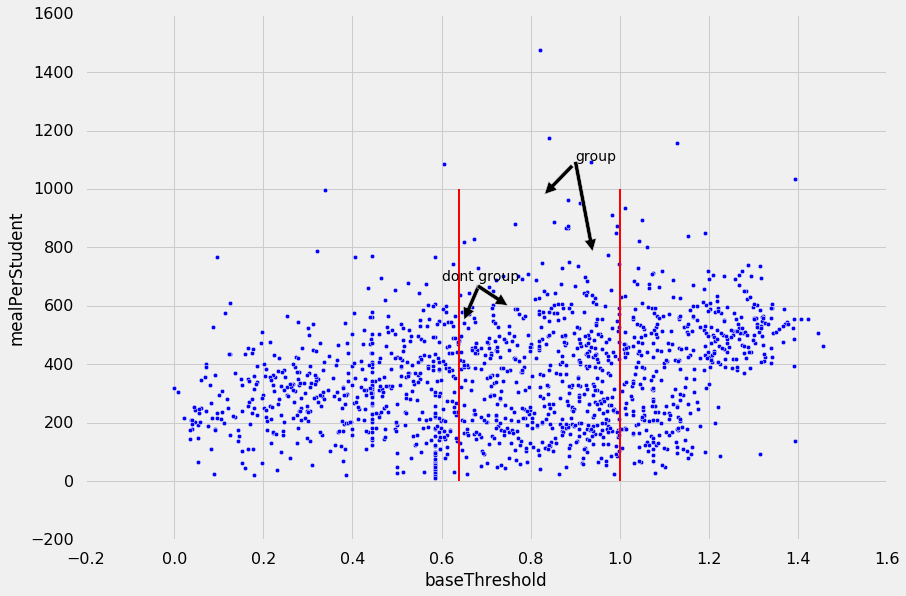

In [10]:
ax=cep.plot.scatter(x='baseThreshold',y='mealPerStudent')

ax.annotate('group', xy=(.83, 980), xytext=(.9, 1100),
            arrowprops=dict(facecolor='black', shrink=0.02))
ax.annotate('', xy=(.94, 780), xytext=(.9, 1100),
            arrowprops=dict(facecolor='black', shrink=0.02))

ax.annotate('dont group', xy=(.65, 550), xytext=(.6, 690),
            arrowprops=dict(facecolor='black', shrink=0.02))
ax.annotate('', xy=(.75, 600), xytext=(.68, 670),
            arrowprops=dict(facecolor='black', shrink=0.02))
plt.plot([t_min,t_min],[0,1000],'r-',lw=2)
plt.plot([1,1],[0,1000],'r-',lw=2)

(53, 9)


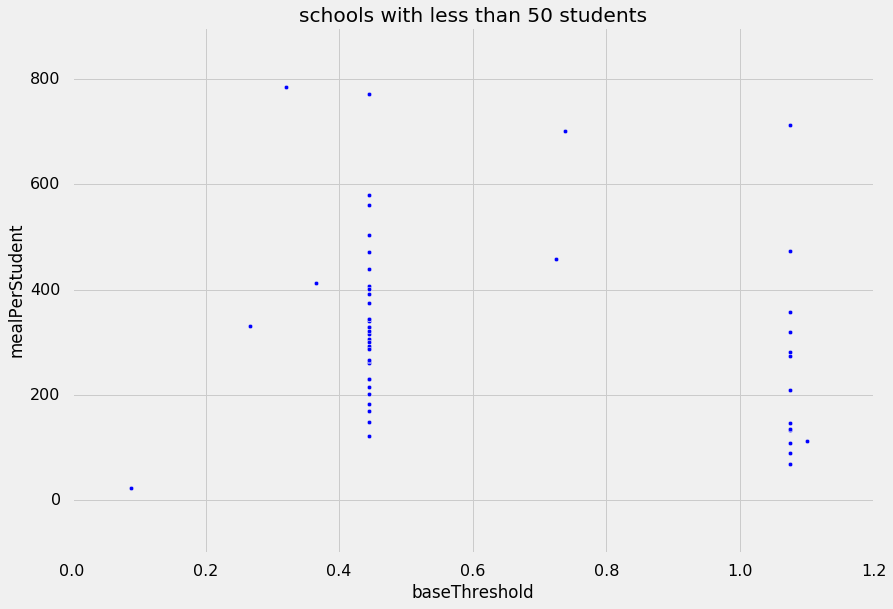

In [11]:
print cep[cep.Enrollment<50].shape
cep[cep.Enrollment<50].plot.scatter(x='baseThreshold',y='mealPerStudent',
                                    title='schools with less than 50 students')

For schools with less students, the meal projections are probably not very accurate.

## Calculating Reimbursements based on school groupings

In [12]:
# all meals are reimbursed at a minimum at the paid rate
# the base reimbursement is independant of groupings and is equal to 
# the lowest reimbursements rates (i.e. "paid" rates) times the total number of each meal
baseReimburse = paidLunch*cep.Lunch.sum() + paidBreakfast*cep.Breakfast.sum()

# reimbursements over the base, this is the part that's dependant on groupings
def calcReimburse(df,result):
    ''' 
    calculates the reimbursements per school. 
    Each row in df is a school.
    Updates df 'threshold' and 'reimburse' columns.
    Results stored in results list
    ''' 
    # calc threshold.(can be >1)
    for i in set(df.group):
        df.loc[df.group == i,'threshold'] = groupThreshold(df[df.group==i])
    
    # based on threshold, calculate reimbursement for each row
    df['reimburse'] = df['meal']*(df['threshold'].apply(lambda x: min(x,1)))

    # store 'results' as a list of lists. 
    #     The inner lists 0th item saves info about the groupings,
    #     the 1st item is the number of groups
    #     the 2nd item is the reimbusement (above base reimbursement)
    #     the 3rd item is whether or not the threshold has been met for the goups
    if df['threshold'].min() >= .40*multiplier:
        result.append([df[['group','threshold','meal']].copy(),len(set(df.group)),
                        df.reimburse.sum(),'threshold met'])
    else:
        result.append([df[['group','threshold','meal']].copy(),len(set(df.group)),
                       df.reimburse.sum(),'threshold not met'])
    return result

def groupReimburse(df):
    '''given a dataframe df, assuming all rows are in the same 'group', this calculates the
    reimbursements for the full group'''
    td = groupThreshold(df)
    ml = df['meal'].sum() 
    return (ml)*min(td,1)

def groupThreshold(df):
    '''given a dataframe df, assuming all rows are in the same 'group', this calculates the
    'threshold' for the full group'''
    return (df['Identified'].sum()) / float(df['Enrollment'].sum())*multiplier
    

def deltaReimburse(df,group1,group2):
    '''difference in reimbursement with combining groups vs separate'''
    df12 = df[(df['group'] == group1)|(df['group'] == group2)].copy()
    r12 = groupReimburse(df12)

    df1 = df[df['group'] == group1].copy()
    r1 = groupReimburse(df1)
     
    df2 = df[df['group'] == group2].copy()
    r2 = groupReimburse(df2)

    return r12 - r1 - r2

In [13]:
# testing with a smaller set of schools
cep = cep.sample(100)
cep.reset_index(inplace=True)
cep.shape

(100, 10)

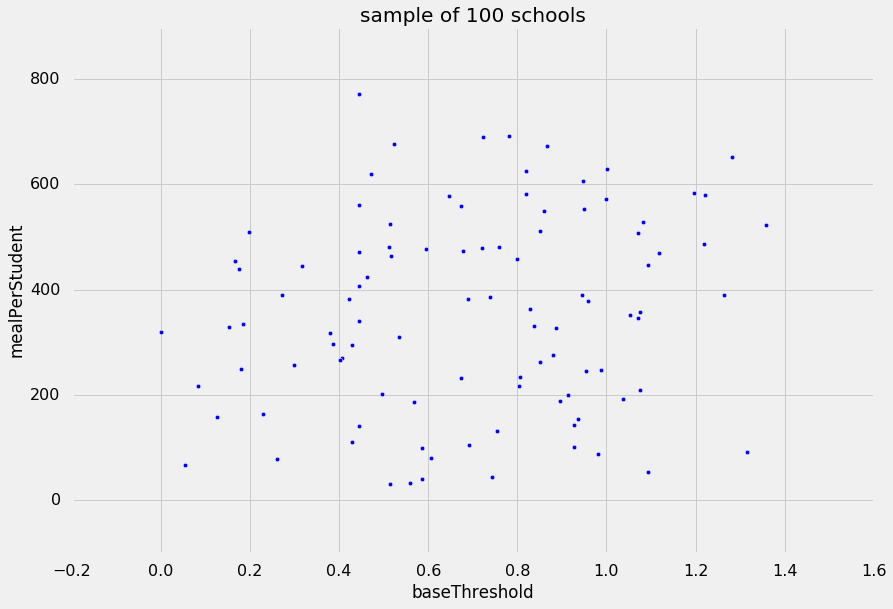

In [14]:
cep.plot.scatter(x='baseThreshold',y='mealPerStudent',title='sample of 100 schools')

In [15]:
#initializing results as a list. This is where the groupings and reimbursements will be stored
results = []
tempResults = [] #throw away results

# this implementation of threshold only for each school separately
# each school is it's own group to start with
cep['group']=cep.index
results = calcReimburse(cep, results)
#print out latest result: number of groups, reimbursement, and threshold met
results[-1][1:]


[100, 10800977.486396303, 'threshold not met']

In [16]:
cep.head()

,index,School,Enrollment,Identified,Breakfast,Lunch,meal,mealPerStudent,baseThreshold,group,threshold,reimburse
0,800,16959,196.0,91.0,46.186694,2975.542742,8595.451438,43.854344,0.742857,0,0.742857,6385.192497
1,1066,23244,617.0,323.0,25133.958871,55120.253522,204116.615025,330.821094,0.837601,1,0.837601,170968.341402
2,1230,27273,361.0,171.0,20607.662903,47288.802240,173349.543115,480.192640,0.757895,2,0.757895,131380.706361
3,1009,21215,901.0,416.0,32977.299194,100231.460893,347637.004362,385.834633,0.738735,3,0.738735,256811.531746
4,920,19224,448.0,342.0,51855.060484,57470.242742,260244.901077,580.903797,1.221429,4,1.221429,260244.901077


In [17]:
print 'base reimbursements', "{:.2E}".format(baseReimburse)
possReimb = [x[2] for x in results]
print 'above base', "{:.2E}".format(max(possReimb))

base reimbursements 3.77E+07
above base 1.08E+07


In [18]:
# put all schools in one group and calculate reimbursements
cep['group']=0
calcReimburse(cep, results)
"{:.2e}".format(results[-1][2])

'1.06e+07'

In [19]:
# if every meal were reimbursed at the free rate, this is the number of dollars per student
# would be spent above the base (paid) rate. 
m0=cep.meal.sum()/cep.Enrollment.sum()
m0

322.55537525135634

In [20]:
possReimb = [x[2] for x in results]
print 'saved', "{:.2E}".format(max(possReimb)-min(possReimb))
print 'max', possReimb.index(max(possReimb))
print 'min', possReimb.index(min(possReimb))

saved 1.89E+05
max 0
min 1


In [21]:
# random
#numberOfGroups = 5
#school['group'] = school[:numberOfGroups].sample(school.shape[0],replace=True).index
#results = calcReimburse(school, results)

## Method 1: Grouping by two

In [22]:
#initialize deltaR
cep['group']=cep.index
tempResults=[]
tempResults = calcReimburse(cep,tempResults)
index = list(set(cep.group))
deltaR = pd.DataFrame(0,columns=index,index=index)

startTime = time.time()
for i in index:
    for j in index:
        if i < j: #can probably optimize this
            deltaR.loc[i,j] = deltaReimburse(cep,i,j)

midTime = time.time()

while (deltaR.values.max() > 0):
    # the max value of deltaR, if it's >0, determines the groups to be combined
    # if max is <=0 then no further combination will increase reimbursements
    
    # the index and column location of the max value
    indLoc = np.where(deltaR == deltaR.values.max())[0][0] 
    colLoc = np.where(deltaR == deltaR.values.max())[1][0]
    
    # the index location corresponds to the first group, the column location to the second group
    # note the firstGroup number is smaller than the secondGroup.
    firstGroup = index[indLoc]
    secondGroup = index[colLoc]
    
    #drop the row/col of the second group in deltaR (it will be combined with the first group)
    deltaR.drop(secondGroup,axis=0, inplace=True)
    deltaR.drop(secondGroup,axis=1,inplace=True)
    
    #combining groups in the school df
    cep.loc[cep.group==secondGroup,'group']=firstGroup
    
    #reset index
    index = list(set(cep.group))
    #loop through the row of deltaR corresponding to the new grouping
    for i in index:
        if i>firstGroup:
            deltaR.loc[firstGroup,i] = deltaReimburse(cep,firstGroup,i)

endTime = time.time()
print endTime - startTime
results = calcReimburse(cep, results)
deltaR

28.3567650318


,0,1,2,3,5,8,9
0,0,-536239.872849,-492690.295328,-117909.890694,-16953.050333,-8712.511181,-3376.946598
1,0,0.000000,-8164.444571,-23166.003954,-251676.440925,-178825.375287,-159656.316116
2,0,0.000000,0.000000,-43580.504565,-283290.093414,-206570.373100,-189333.909578
3,0,0.000000,0.000000,0.000000,-96237.800599,-51139.043638,-24660.012109
5,0,0.000000,0.000000,0.000000,0.000000,-30826.839797,-22656.122937
8,0,0.000000,0.000000,0.000000,0.000000,0.000000,-284.100026
9,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [23]:
endTime - startTime

28.356765031814575

In [24]:
possReimb = [x[2] for x in results]
print 'saved', "{:.2E}".format(max(possReimb)-min(possReimb))
print 'max', possReimb.index(max(possReimb))
print 'min', possReimb.index(min(possReimb))

saved 1.03E+06
max 2
min 1


In [25]:
[x[2] for x in results]

[10800977.486396303, 10612454.825804099, 11644328.000522658]

In [26]:
[x[1] for x in results]

[100, 1, 7]

## ungrouping by two

In [27]:
ttarget = 1
tlowerbound = t_min

#start with everyschool in the same group
t0 = groupThreshold(cep)

#check to see if t0 is within bounds
if (t0<tlowerbound):
    print 'error - schools dont qualify'
if (t0>=ttarget):
    print 'done - cant do better than that!'
print 't0 =',t0

t0 = 0.688477652078


In [28]:
cep.group = 0
t0 = groupThreshold(cep)

df = cep.copy()
ungroup = []

while(t0<ttarget):
    index = df[(df.baseThreshold<t0)&(df.baseThreshold>tlowerbound)].index
    deltaR = pd.Series(0,index=index)

    for i in index:
        df.group = 0
        df.loc[i,'group'] = 1
        deltaR.loc[i] = deltaReimburse(df,1,0)
    
    if (deltaR.min()<0):
        ungroup.append(deltaR.idxmin())
        df.drop(deltaR.idxmin(),inplace=True)
        t0 = groupThreshold(df)
    else:
        break

print t0
ungroup

0.688547736482


[63]

In [29]:
cep.group=cep.index
cep.loc[~cep.index.isin(ungroup),'group']=10000
results = calcReimburse(cep,results)
[x[2] for x in results]

[10800977.486396303,
 10612454.825804099,
 11644328.000522658,
 10612760.082775289]

In [30]:
cep.group=0
cep.loc[~cep.index.isin(ungroup),'group']=10000
results = calcReimburse(cep,results)

In [31]:
[x[1:] for x in results]

[[100, 10800977.486396303, 'threshold not met'],
 [1, 10612454.825804099, 'threshold met'],
 [7, 11644328.000522658, 'threshold not met'],
 [2, 10612760.082775289, 'threshold met'],
 [2, 10612760.082775289, 'threshold met']]

In [36]:
results[4]

[    group  threshold           meal
 0   10000   0.688548    8595.451438
 1   10000   0.688548  204116.615025
 2   10000   0.688548  173349.543115
 3   10000   0.688548  347637.004362
 4   10000   0.688548  260244.901077
 5   10000   0.688548   41533.745736
 6   10000   0.688548  319541.802356
 7   10000   0.688548   36772.035807
 8   10000   0.688548  153992.724444
 9   10000   0.688548   77221.490979
 10  10000   0.688548  287095.433200
 11  10000   0.688548  144372.869173
 12  10000   0.688548  100224.092098
 13  10000   0.688548    4440.959753
 14  10000   0.688548   58107.118057
 15  10000   0.688548  329288.171328
 16  10000   0.688548  411598.804627
 17  10000   0.688548  355950.193193
 18  10000   0.688548   51031.574131
 19  10000   0.688548    6601.608098
 20  10000   0.688548  113179.620592
 21  10000   0.688548  264916.503638
 22  10000   0.688548   56519.519363
 23  10000   0.688548  398874.061280
 24  10000   0.688548  238434.494999
 25  10000   0.688548  199730.578213
 

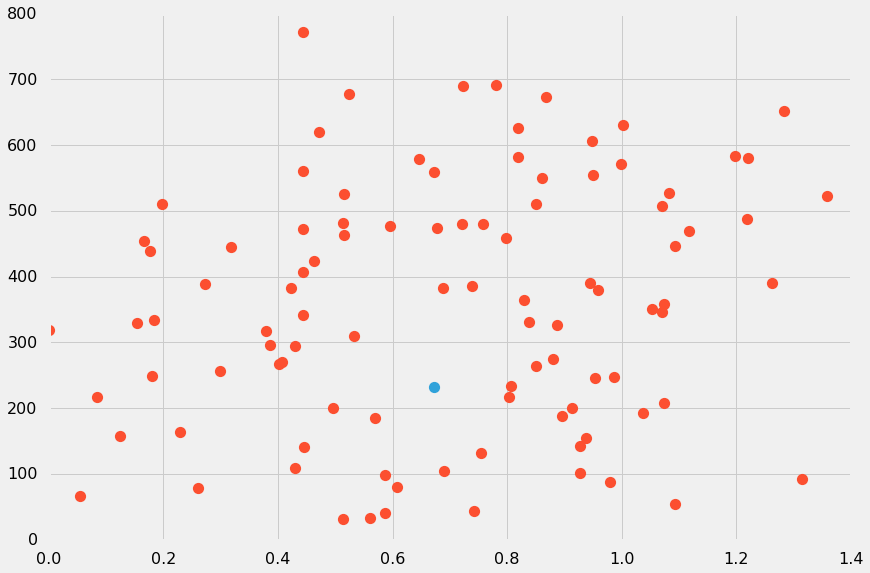

In [35]:
groups = cep.groupby('group')
for name, group in groups:
    plt.plot(group.baseThreshold, group.mealPerStudent,marker='o',linestyle='', label=name)

In [42]:
cep.group = 0
t0 = groupThreshold(cep)

df = cep.copy()
ungroup = []

while(t0<ttarget):
    index = df[df.baseThreshold<t0].index
    deltaR = pd.Series(0,index=index)

    for i in index:
        df.group = 0
        df.loc[i,'group'] = 1
        deltaR.loc[i] = deltaReimburse(df,1,0)
    
    if (deltaR.min()<0):
        ungroup.append(deltaR.idxmin())
        df.drop(deltaR.idxmin(),inplace=True)
        t0 = groupThreshold(df)
    else:
        break

print t0
len(ungroup)

0.851672852953


40

In [43]:
cep.group=0
cep.loc[~cep.index.isin(ungroup),'group']=10000
results = calcReimburse(cep,results)

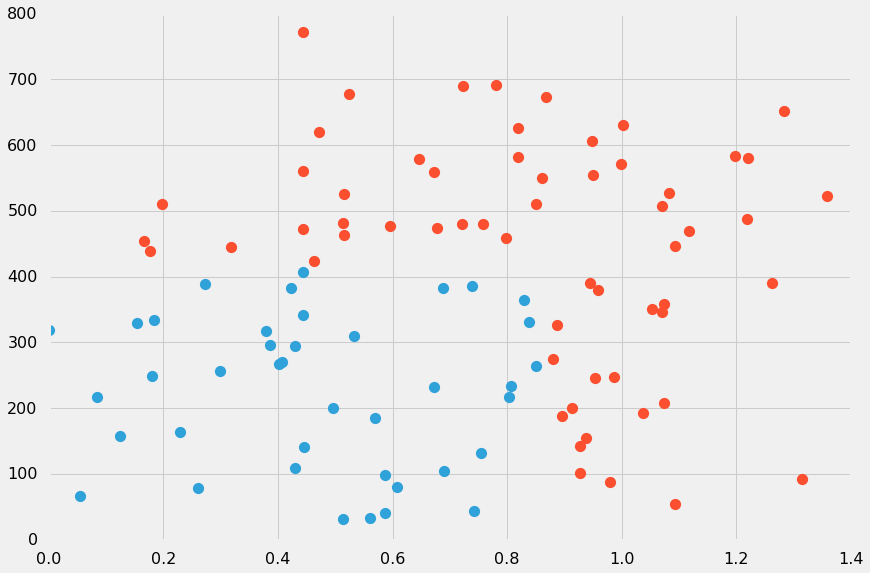

In [44]:
groups = cep.groupby('group')
for name, group in groups:
    plt.plot(group.baseThreshold, group.mealPerStudent,marker='o',linestyle='', label=name)

In [45]:
cep.head(10)

,index,School,Enrollment,Identified,Breakfast,Lunch,meal,mealPerStudent,baseThreshold,group,threshold,reimburse
0,800,16959,196.000000,91.0,46.186694,2975.542742,8595.451438,43.854344,0.742857,0,0.489197,4204.865625
1,1066,23244,617.000000,323.0,25133.958871,55120.253522,204116.615025,330.821094,0.837601,0,0.489197,99853.154210
2,1230,27273,361.000000,171.0,20607.662903,47288.802240,173349.543115,480.192640,0.757895,10000,0.851673,147637.099943
3,1009,21215,901.000000,416.0,32977.299194,100231.460893,347637.004362,385.834633,0.738735,0,0.489197,170062.840800
4,920,19224,448.000000,342.0,51855.060484,57470.242742,260244.901077,580.903797,1.221429,10000,0.851673,221643.517366
5,68,2412,529.000000,86.0,2414.304435,12961.432460,41533.745736,78.513697,0.260113,0,0.489197,20318.167227
6,1313,29034,571.000000,240.0,52062.200806,78069.508065,319541.802356,559.617868,0.672504,10000,0.851673,272145.078450
7,944,19645,239.000000,140.0,2519.274194,11228.635602,36772.035807,153.857890,0.937238,10000,0.851673,31317.744645
8,1340,29327,498.000000,166.0,17728.692339,42381.948360,153992.724444,309.222338,0.533333,0,0.489197,75332.717325
9,867,18035,416.333333,148.0,8608.919758,21434.824597,77221.490979,185.479962,0.568775,0,0.489197,37776.490886


## Method 3: find max/min threshold for all schools
set the max threshold at the school that has the greatest difference between min/max possible reimbursements.
recalculate min/max thresholds with remaining schools and repeat

DROP - this doesn't seem to work.

In [207]:
def calcBounds(sminmax):
    '''calculate upper and lower bounds to reimbursements'''
    sminmax['group'] = sminmax.index
    tempResults = []
    calcReimburse(sminmax,tempResults)     
    for i in sminmax.index.values:
        sminmax.group = sminmax.index
        #define tgroup to hold original threshold values, drop one by one highest to lowest
        tgroup = sminmax.threshold.copy()
        # initialize the new threshold
        newt = sminmax.loc[i].threshold 
        while (newt < tgroup.max()) and (newt<1):
            #combine the group with the maximum threshold with group i
            #calculate the new threshold of that combined group
            #new indicies to include in threshold calculation
            newIndex = tgroup[tgroup==tgroup.max()].index
            dftemp = sminmax[(sminmax.group==i)|\
                             (sminmax.index.isin(newIndex))].copy()
            #calculate new threshold
            newnewt = dftemp['Identified'].sum() / float(dftemp['Enrollment'].sum())*multiplier
            if newnewt<1:
                #only save this group if the new value of the threshold is<1
                sminmax.loc[newIndex,'group']=i
                # drop tmax from group and start over
                tgroup.drop(newIndex,inplace=True)
                newt=newnewt
            else:
                break
        #store the max threshold tmax, and the groupings that made it gmax.
        sminmax.loc[i,'tmax'] = newt
        sminmax.loc[i,'gmax'] = ','.join(str(x) for x in (sminmax[sminmax.group==i].index.values))
    
    sminmax['rmax'] = sminmax['meal']*(sminmax['tmax'].apply(lambda x:min(x,1)))
    sminmax['rover'] = sminmax['meal']*sminmax['tmax'] - sminmax['rmax']

    #calculate lower bound to reimbursement
    for i in sminmax.index.values:
        # set to individual groups (thesholds already set above)
        sminmax.group = sminmax.index
    
        #define tgroup to hold original threshold values, drop one by one highest to lowest
        tgroup = sminmax.threshold.copy()
        # initialize the new threshold
        newt = sminmax.loc[i].threshold 
        while (newt > tgroup.min()):
            #combine the group with the minimum threshold with group i
            sminmax.loc[tgroup[tgroup==tgroup.min()].index,'group']=i
            #calculate the new threshold of that combined group
            dftemp = sminmax[sminmax.group==i].copy()
            newt = dftemp['Identified'].sum() / float(dftemp['Enrollment'].sum())*multiplier
            # drop tmin from group and start over
            tgroup.drop(tgroup[tgroup==tgroup.min()].index,inplace=True)
        #store the min threshold tmin, and the groupings that made it gmin.
        sminmax.loc[i,'tmin'] = newt
        sminmax.loc[i,'gmin'] = ','.join(str(x) for x in (sminmax[sminmax.group==i].index.values))

    sminmax['rmin'] = sminmax['meal']*(sminmax['tmin'].apply(lambda x:min(x,1)))
    
    sminmax['rmax-rmin'] = sminmax['rmax'] - sminmax['rmin']
    sminmax['rmax-rmin-rover'] = sminmax['rmax-rmin'] - sminmax['rover']
    sminmax['rmax-r'] = sminmax['rmax'] - sminmax['reimburse']


In [227]:
sbounds = school[['Name','Enrollment','Identified','Lunches',
               'Breakfasts','group']].copy()
calcBounds(sbounds)

print "{:2e}".format(sbounds.rmax.sum())

8.405688e+06


In [ ]:
sbounds[['gmax','rmax','reimburse','rmax-rmin']].sort_values('rmax-rmin')

In [ ]:
# set the groups in order of the largest reimbursement difference (rmax-rmin)
school.group = school.index
sbound = school[['Name','Enrollment','Identified','Lunches',
               'Breakfasts','meal','group','threshold']].copy()

while(sbound.shape[0]>0):
    calcBounds(sbound)
    indexMax = sbound['rmax-rmin'].idxmax()
    groupList = map(int,sbound.loc[indexMax].gmax.split(','))
    school.loc[school.index.isin(groupList),'group'] = min(groupList)
    #drop all schools already set
    sbound.drop(groupList,inplace=True)    

results = calcReimburse(school,results)

In [229]:
school.meal.sum()

10620785.85

In [ ]:
# set the groups in order of the largest reimbursement difference (rmax-rmin)
school.group = school.index
sbound = school[['Name','Enrollment','Identified','Lunches',
               'Breakfasts','meal','group','threshold']].copy()

while(sbound.shape[0]>0):
    calcBounds(sbound)
    indexMax = sbound['rmax'].idxmax()
    groupList = map(int,sbound.loc[indexMax].gmax.split(','))
    school.loc[school.index.isin(groupList),'group'] = min(groupList)
    #drop all schools already set
    sbound.drop(groupList,inplace=True)    

results = calcReimburse(school,results)

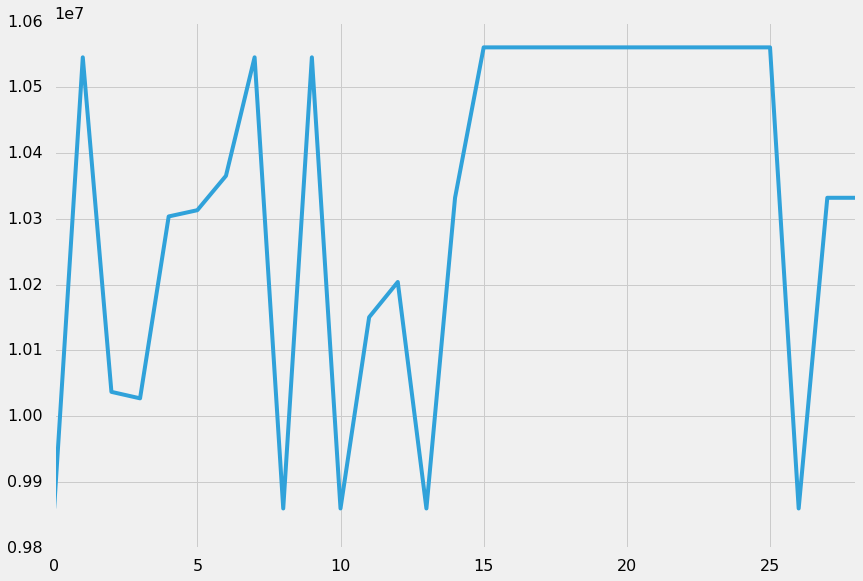

In [131]:
pd.Series([x[2] for x in results]).plot()

In [132]:
[x[2] for x in results]

[9859535.0562031344,
 10545816.781614168,
 10036904.071577815,
 10027063.236628737,
 10303768.207755748,
 10313260.413609516,
 10365591.788532862,
 10545816.781614168,
 9859535.0562031344,
 10545816.781614168,
 9859535.0562031344,
 10150474.930772413,
 10204059.767045012,
 9859535.0562031344,
 10332152.594735747,
 10560964.023968218,
 10560964.023968218,
 10560964.023968218,
 10560964.023968218,
 10560964.023968218,
 10560964.023968218,
 10560964.023968218,
 10560964.023968218,
 10560964.023968218,
 10560964.023968218,
 10560964.023968218,
 9859535.0562031344,
 10332152.594735747,
 10332152.594735747]